# Programming Assignment 3: Recurrent Neural Networks and Transformer

### Instructor: Yuanyuan Shi

### Teaching Assistants

- Yuexin Bian, [yubian@ucsd.edu]
- Tz-Ying Wu, [tzw001@ucsd.edu]

## Instructions
1. This assignment must be completed individually.  
2. This notebook contains skeleton code, which should not be modified
3. You must run all cells in this notebook and submit this notebook as an .ipynb file.
4. You must submit the .ipynb on Gradescope. You must mark each problem on Gradescope in the pdf.

## Setup

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Comment it if you are not using mac
# %config InlineBackend.figure_format = 'retina'

## Part1. RNN models for prediction (30 points)
### In this part you will
### 1. Implement RNNcell (5 points)
### 2. Implement a single-layer RNN (5 points)
### 3. Implement a RNN-based predictor (5 points)
### 4. Implement functions of loss and training (5 points)
### 5. Conduct experiments (10 points)

### <font size='4' color='orange'>Task 1.1: Implement a RNNCell (5 points)</font>

In [22]:
# Documentation of nn.Module https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
class RNNCell(torch.nn.Module):
    """
    RNNCell is a single cell that takes x_t and h_{t-1} as input and outputs h_t.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of RNNCell.
        
        Inputs: 
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        
        # We always need to do this step to properly implement the constructor
        super(RNNCell, self).__init__()
        
        self.linear_x, self.linear_h, self.non_linear = None, None, None  
        
        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer. You can use tanh here.                            #
        ###########################################################################
        self.linear_x = nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True)
        self.linear_h = nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True)
        self.non_linear = nn.Tanh()
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x_cur: torch.Tensor, h_prev: torch.Tensor):
        """
        Compute h_t given x_t and h_{t-1}.
        
        Inputs:
        - x_cur: x_t, a tensor with the same of BxC, where B is the batch size and 
          C is the channel dimension.
        - h_prev: h_{t-1}, a tensor with the same of BxH, where H is the channel
          dimension.
        """
        h_cur = None
        ###########################################################################
        # TODO: Define the linear transformation layers for x_t and h_{t-1} and   #
        # the non-linear layer.                                                   #
        ###########################################################################
        out_x = self.linear_x(x_cur.clone())
        out_h = self.linear_h(h_prev.clone())
        h_cur = self.non_linear(out_x + out_h)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return h_cur

In [23]:
# Let's run a sanity check of your model
x = torch.randn((2, 8))
h = torch.randn((2, 16))
model = RNNCell(input_dim=8, hidden_dim = 16)
y = model(x, h)
assert len(y.shape) == 2 and y.shape == (2,16)
print(y.shape)

torch.Size([2, 16])


### <font size='4' color='orange'>Task 1.2: Implement a single-layer (single-stack) RNN (5 points)</font>

In [24]:
class RNN(torch.nn.Module):
    """
    RNN is a single-layer (stack) RNN by connecting multiple RNNCell together in a single
    direction, where the input sequence is processed from left to right.
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Constructor of the RNN module.
        
        Inputs: 
        - input_dim: Dimension of the input x_t
        - hidden_dim: Dimension of the hidden state h_{t-1} and h_t
        """
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        ###########################################################################
        # TODO: Define the RNNCell.                                               #
        ###########################################################################

        self.rnn_cell = RNNCell(input_dim, hidden_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor):
        """
        Compute the hidden representations for every token in the input sequence.
        
        Input:
        - x: A tensor with the shape of BxLxC, where B is the batch size, L is the squence 
          length, and C is the channel dimmension
          
        Return:
        - h: A tensor with the shape of BxLxH, where H is the hidden dimension of RNNCell
        """
        b = x.shape[0]
        seq_len = x.shape[1]
        
        # initialize the hidden dimension
        init_h = x.new_zeros((b, self.hidden_dim))
        
        h = None
        ###########################################################################
        # TODO: Compute the hidden representation for every token in the input    #
        # from left to right.
        ###########################################################################
        h = torch.zeros((b, seq_len, self.hidden_dim))
        for i in range(seq_len):
            h[:, i, :] = self.rnn_cell(x[:, i, :], init_h)
            init_h = h[:, i, :]
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return h
        

In [25]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
model = RNN(input_dim=8, hidden_dim=16)
y = model(x)
assert len(y.shape) == 3 and y.shape == (2,10,16)
print(y.shape)

torch.Size([2, 10, 16])


### <font size='4' color='orange'>Task 1.3: Implement a RNN-based predictor (5 points)</font>
### use the final hidden state to to generate the output

In [26]:
class RNNmodel(nn.Module):
    """
    A RNN-based predictor
    """
    def __init__(self, 
            input_dim: int, rnn_hidden_dim: int, output_dim: int
        ):
        """
        Constructor.
        
        Inputs:
        - input_dim: input dimension of the sequence
        - rnn_hidden_dim: The hidden dimension of the RNN.
        - output_dim: output dimension
        - pred_type: 'all' or 'last'
        """
        super(RNNmodel, self).__init__()
        self.rnn, self.fc = None, None
        
        ###########################################################################
        # TODO: Define the RNN and the predictor layer.                           #
        ###########################################################################

        self.rnn = RNN(input_dim, rnn_hidden_dim)
        self.fc = nn.Linear(rnn_hidden_dim, output_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def init_weights(self):
        initrange = 0.1
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, x):
        """
        Get the prediction result of the input based on the predictor type
        
        Input:
        - x: Tensor with the shape of BxLxC.
        
        Return:
        - y: Tensor with the shape of BxO, where O is the output dimension
        """
        
        y = None
        ###########################################################################
        # TODO: Compute logits of the input.                                      #
        ###########################################################################

        out_rnn = self.rnn(x)
        y = self.fc(out_rnn[:, -1, :]) #use only last layer 

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [27]:
# Let's run a sanity check of your model
input_dim = 4
length = 5
batch_size = 2
rnn_hidden_dim = 10
output_dim = 2

x = torch.randn(batch_size, length, input_dim)
print('x.shape: {}'.format(x.shape))
model = RNNmodel(input_dim, rnn_hidden_dim, output_dim)
y = model(x)
assert y.shape == (batch_size, output_dim)
print(y.shape)

x.shape: torch.Size([2, 5, 4])
torch.Size([2, 2])


### <font size='4' color='orange'>Task 1.4: Functions of training for a single epoch and evaluation (5 points)</font>

In [36]:
import time

def train(model, dataloader, loss_func, device, grad_norm_clip):
    model.train()
    total_mse, total_count = 0, 0
    log_interval = 100
    start_time = time.time()

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        
        y_pred = None
        ###########################################################################
        # TODO: compute the prediction of the input, get the loss, and do the     #
        # gradient backpropagation.
        ###########################################################################

        y_pred = model(X)
        loss = loss_func(y_pred, y)
        loss.backward()

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        optimizer.step()
        total_mse += loss.item()
        total_count += X.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| MSE {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_mse/total_count))
            total_mse, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device, normalize=True):
    """
    If you normalize the data, you should process the prediction and data into raw value and measure the MSE
    Normalize function is provided in the following ''createSamples'' function. 
    """
    model.eval()
    total_mse, total_count = 0, 0

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            
            ###########################################################################
            # TODO: compute the prediction of the input, get the loss.                #
            # If normlize the data, multiply the prediction value and true value by its range
            ###########################################################################
            y_pred = model(X)
            loss = loss_func(y_pred, y)
            if normalize:
              y_pred = y_pred * (y.max() - y.min())
              y = y * (y.max() - y.min())
        
            
            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################
            
            total_mse += loss.item()
            total_count += X.size(0)
    return total_mse/total_count

### <font size='4' color='orange'>Task 1.5: Load data and train the model (10 points)</font>
### You are expected to achieve < 550 validate MSE for non-normalized data using RNN model
### You are expected to achieve < 1 validate MSE for normalized data using RNN model

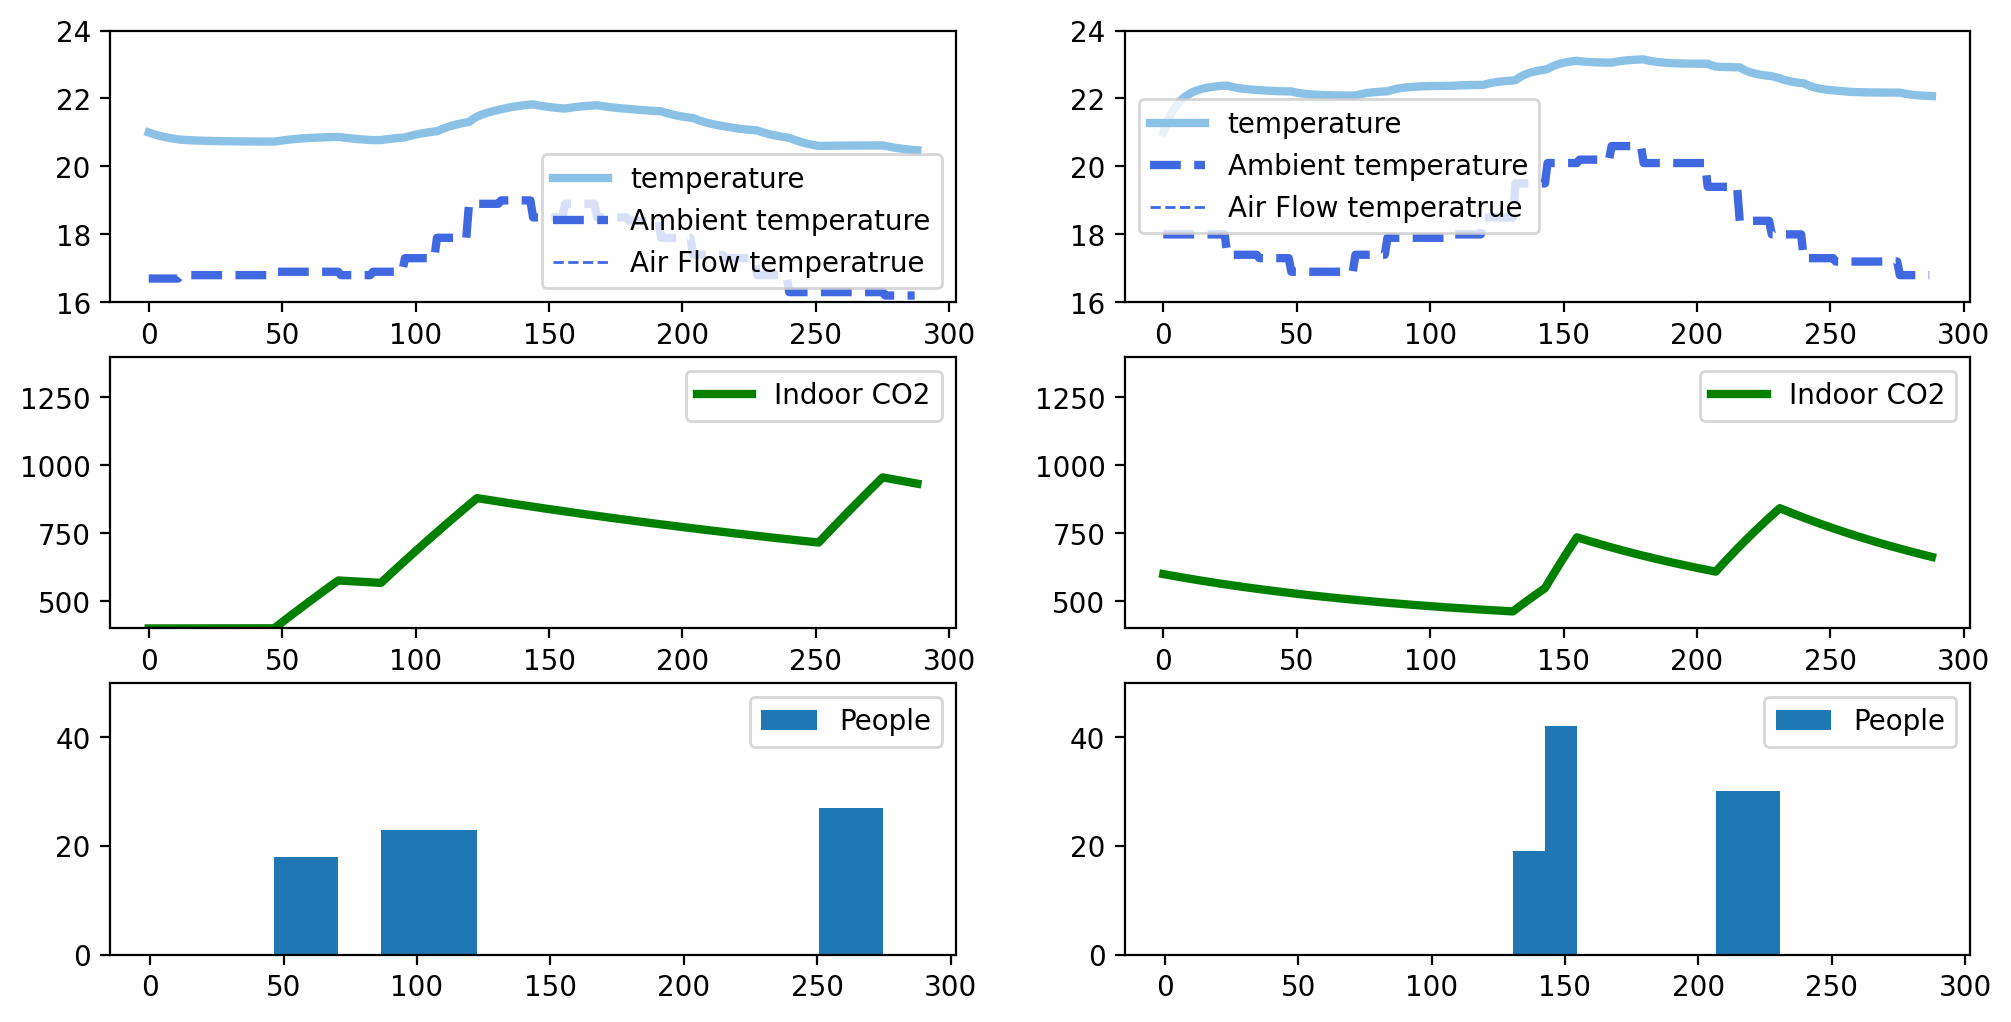

In [37]:
def plot(data):
    fig, ax = plt.subplots(3,2, figsize=(12, 6))
    temp = data['temp'] 
    co2 = data['co2']
    people = data['d']
    u1 = data['u1']
    u2 = data['u2']
    amb = data['amb']
    show = [0,5]
    for idx in range(2):
        ax[0][idx].plot(temp[show[idx]], label='temperature', color='#8cc1e6', linewidth=3)
        ax[0][idx].plot(amb[show[idx]], label='Ambient temperature', linestyle='--', color='#4069e1', linewidth=3)
        ax[0][idx].plot(np.ones(288)*u1[show[idx]], label='Air Flow temperatrue', linestyle='--', color='#4069e1', linewidth=1)
        ax[1][idx].plot(co2[show[idx]], label='Indoor CO2',  color='green', linewidth=3)
        ax[2][idx].bar(list(range(288)), people[show[idx]], width=1.0, label='People')
        ax[1][idx].set_ylim([400, 1400])
        ax[2][idx].set_ylim([0, 50])
        ax[0][idx].set_ylim([16,24])
    for i in range(3):
        for idx in range(2):
            ax[i][idx].legend()
    plt.savefig('data.png', dpi=300)
    plt.show()

data = np.load('/content/drive/MyDrive/ECE 228 PA3/simulation_data_pa3.npz')


plot(data)

In [38]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
BoolTensor = torch.cuda.BoolTensor if use_cuda else torch.BoolTensor
Tensor = FloatTensor

def createSamples(data, lookBack, normalize=False):
    dataX = []
    dataY = []
    temp, co2, people, u1, u2, amb = data['temp'], data['co2'], data['d'], data['u1'], data['u2'], data['amb']
    if normalize:
        # divide variable of its range
        temp /= 30
        co2 /= 2000
        people /= 100
        u1 /= 30
        u2 /= 20
        amb /= 30
    B, T = temp.shape
    u1 = np.repeat(u1, T, axis=1)
    u2 = np.repeat(u2, T, axis=1)
    for t in range(T-lookBack):
        x = np.stack([temp[:,t:t+lookBack], co2[:,t:t+lookBack], people[:,t:t+lookBack], u1[:,t:t+lookBack], u2[:,t:t+lookBack], amb[:,t:t+lookBack]], axis=-1)
        y = np.concatenate([temp[:,t+lookBack:t+lookBack+1], co2[:,t+lookBack:t+lookBack+1]], axis=1)
        dataX.append(x)
        dataY.append(y)
    X = np.concatenate(dataX, axis=0)
    Y = np.concatenate(dataY, axis=0)
    return Tensor(X), Tensor(Y)

In [48]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset

# TODO: try different Hyper parameters
epochs = 50 # epoch
lr = 1e-2 # learning rate
batch_size = 64 # batch size for training
rnn_hidden_dim = 30
input_dim = 6
output_dim = 2

model, loss_func = None, None
###########################################################################
# TODO: Deinfe the classifier and loss function.
###########################################################################
model = RNNmodel(input_dim, rnn_hidden_dim, output_dim)
loss_func = nn.MSELoss()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################


model = model.to(device)
total_mse = None
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)

# Change the normalize parameters here to conduct experiment for normalized data or the raw data
X, y = createSamples(data, lookBack=24, normalize=False)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(1, epochs + 1, 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, 1)
    mse_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_mse is not None and total_mse > mse_val:
        scheduler.step()
    else:
        total_mse = mse_val
    if epoch == 5000:
        optimizer.param_groups[0]['lr'] = 5e-2
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid mse {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           mse_val))
    #print('-' * 59)

| epoch   1 |   100/  103 batches | MSE 5422.016
-----------------------------------------------------------
| end of epoch   1 | time:  1.21s | valid mse 5459.423 
| epoch   2 |   100/  103 batches | MSE 5038.680
-----------------------------------------------------------
| end of epoch   2 | time:  1.18s | valid mse 5083.669 
| epoch   3 |   100/  103 batches | MSE 4678.649
-----------------------------------------------------------
| end of epoch   3 | time:  1.20s | valid mse 4732.874 
| epoch   4 |   100/  103 batches | MSE 4360.709
-----------------------------------------------------------
| end of epoch   4 | time:  1.72s | valid mse 4405.971 
| epoch   5 |   100/  103 batches | MSE 4055.746
-----------------------------------------------------------
| end of epoch   5 | time:  1.80s | valid mse 4101.826 
| epoch   6 |   100/  103 batches | MSE 3768.753
-----------------------------------------------------------
| end of epoch   6 | time:  1.53s | valid mse 3818.123 
| epoch   

## Part 2: Transformer predictor (50 points)
### In this part you will
### 1. Implement Multi-head attention (5 points)
### 2. Implement a feed-forward NN (5 points)
### 3. Implement a Single Transformer Encoder Cell (5 points)
### 4. Implement Transformer Encoder (5 points)
### 5. Implement Positional Encoding (10 points)
### 6. Implement a Transformer-based predictor (5 points)
### 7. Conduct experiments (10 points)
### 8. Discuss (5 points)

### <font size='4' color='orange'>Task 2.1: Implement the multi-head attention module (no for loops allowed, 5 points)</font>

In [51]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.
        
        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()
        
        assert input_dim % num_heads == 0
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads
        
        ###########################################################################
        # TODO: Define the linear transformation layers for key, value, and query.#
        # Also define the output layer.
        ###########################################################################
        # K, Q, V

        self.K = nn.Linear(self.input_dim, self.input_dim)
        self.Q = nn.Linear(self.input_dim, self.input_dim)
        self.V = nn.Linear(self.input_dim, self.input_dim)
        self.linear_out = nn.Linear(self.input_dim, self.input_dim)

        # output layer

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.
        
        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]        
        
        dot_prod_scores = None
        ###########################################################################
        # TODO: Compute the scores based on dot product between transformed query,#
        # key, and value. You may find torch.matmul helpful, whose documentation  #
        # can be found at                                                         #
        # https://pytorch.org/docs/stable/generated/torch.matmul.html#torch.matmul#
        # Remember to devide the doct product similarity scores by square root of #
        # the channel dimension per head.   
        #                                                                         #
        # Since no for loops are allowed here, think of how to use tensor reshape #
        # to process multiple attention heads at the same time.                   #
        ###########################################################################
        # create K, Q, V
        seq_len = query.shape[1]
        q = self.Q(query).reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        k = self.K(key).reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        v = self.V(value).reshape(b, -1, self.num_heads, self.dim_per_head).transpose(1, 2)
        # compute attention scores
        dot_prod_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.dim_per_head, dtype=torch.float32))

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        if mask is not None:
            # We simply set the similarity scores to be near zero for the positions
            # where the attention should not be done. Think of why we do this.
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)
        
        out = None
        ###########################################################################
        # TODO: Compute the attention scores, which are then used to modulate the #
        # value tensor. Finally concate the attended tensors from multiple heads  #
        # and feed it into the output layer. You may still find torch.matmul      #
        # helpful.                                                                #
        #                                                                         #
        # Again, think of how to use reshaping tensor to do the concatenation.    #
        ###########################################################################
        
        # get attended features
        attention_weights = torch.softmax(dot_prod_scores, dim=-1)  # BxHxLxL
        # concatenate the output from different heads
        attended_values = torch.matmul(attention_weights, v)
        attended_values = attended_values.transpose(1, 2).contiguous().view(b, seq_len, -1)
        # output
        out = self.linear_out(attended_values)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return out

In [52]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = MultiHeadAttention(8, num_heads)
y = model(x, x, x, mask)
assert len(y.shape) == len(x.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='orange'>Task 2.2: Implement a Feedforward Network (5 points)</font>

In [55]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        
        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        self.linear1 = nn.Linear(input_dim, ff_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(ff_dim, input_dim)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension
          
        Return:
        - y: Tensor of the shape BxLxC
        """
        
        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        y = x + out

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return x
        

In [57]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
ff_dim = 4
model = FeedForwardNetwork(8, ff_dim)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='orange'>Task 2.3: Implement a Single Transformer Encoder Cell (5 points)</font>

In [58]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()
        
        ###########################################################################
        # TODO: A single Transformer encoder cell consists of 
        # 1. A multi-head attention module
        # 2. Followed by dropout
        # 3. Followed by layer norm (check nn.LayerNorm)
        # https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm
        
        # At the same time, it also has
        # 1. A feedforward network
        # 2. Followed by dropout
        # 3. Followed by layer norm
        ###########################################################################
        self.mult_head_att = MultiHeadAttention(input_dim, num_heads)
        self.dropout_layer = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(input_dim)
        
        self.ff = FeedForwardNetwork(input_dim, ff_dim)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        Returns:
        - y: Tensor of the shape BxLxC
        """
        
        y = None
        ###########################################################################
        # TODO: Get the output of the multi-head attention part (with dropout     #
        # and layer norm), which is used as input to the feedforward network (    #
        # again, followed by dropout and layer norm).                             #
        #                                                                         #
        # Don't forget the residual connections for both parts.                   #
        ###########################################################################
        attn_output = self.mult_head_att(x, x, x, mask)
        attn_output = self.dropout_layer(attn_output)
        attn_output = self.layer_norm(attn_output + x)
        
        ff_output = self.ff(attn_output)
        ff_output = self.dropout_layer(ff_output)
        ff_output = self.layer_norm(ff_output + attn_output)
        
        y = ff_output




        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [59]:
# Let's run a sanity check of your model
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoderCell(8, num_heads, 32, 0.1)
y = model(x, mask)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='orange'>Task 2.4: Implement Transformer Encoder (5 points)</font>

In [61]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        
        self.norm = None
        ###########################################################################
        # TODO: Construct a nn.ModuleList to store a stack of                     #
        # TranformerEncoderCells. Check the documentation here of how to use it   #
        # https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html#torch.nn.ModuleList
        
        # At the same time, define a layer normalization layer to process the     #
        # output of the entire encoder.                                           #
        ###########################################################################
        self.norm = nn.LayerNorm(input_dim)
        self.cells = nn.ModuleList([TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for _ in range(num_cells)])


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """
        
        y = None
        ###########################################################################
        # TODO: Feed x into the stack of TransformerEncoderCells and then         #
        # normalize the output with layer norm.                                   #
        ###########################################################################

        y = x
        for cell in self.cells:
            y = cell(y, mask=mask)
        
        y = self.norm(y)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y
        

In [62]:
# Let's run a sanity check of your model
x = torch.randn((2, 10, 8))
mask = torch.randn((2, 10)) > 0.5
mask = mask.unsqueeze(1).unsqueeze(-1)
num_heads = 4
model = TransformerEncoder(8, num_heads, 32, 2, 0.1)
y = model(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y
print(y.shape)

torch.Size([2, 10, 8])


### <font size='4' color='orange'>Task 2.5: Implement Positional Encoding (10 points)</font>

In [99]:
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()
        
        self.input_dim = input_dim
        
    def forward(self, x):
        """
        Compute the positional encoding and add it to x.
        
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
          
        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]
        
        pe = None
        ###########################################################################
        # TODO: Compute the positional encoding                                   #
        # Check Section 3.5 for the definition (https://arxiv.org/pdf/1706.03762.pdf)
        #                                                                         #
        # It's a bit messy, but the definition is provided for your here for your #
        # convenience (in LaTex).                                                 #
        # PE_{(pos,2i)} = sin(pos / 10000^{2i/\dmodel}) \\                        #
        # PE_{(pos,2i+1)} = cos(pos / 10000^{2i/\dmodel})                         #
        #                                                                         #
        # You should replace 10000 with max_len here.
        ###########################################################################

        seq_len = x.shape[1]
        input_dim = x.shape[2]
        
        pe = torch.zeros(seq_len, input_dim)
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        div_term = seq_len**(torch.arange(0, input_dim, 2).float() / input_dim)
        # div_term = torch.exp(torch.arange(0, input_dim, 2).float() * (-math.log(10000.0) / input_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)


        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        x = x + pe.to(x.device)
        return x

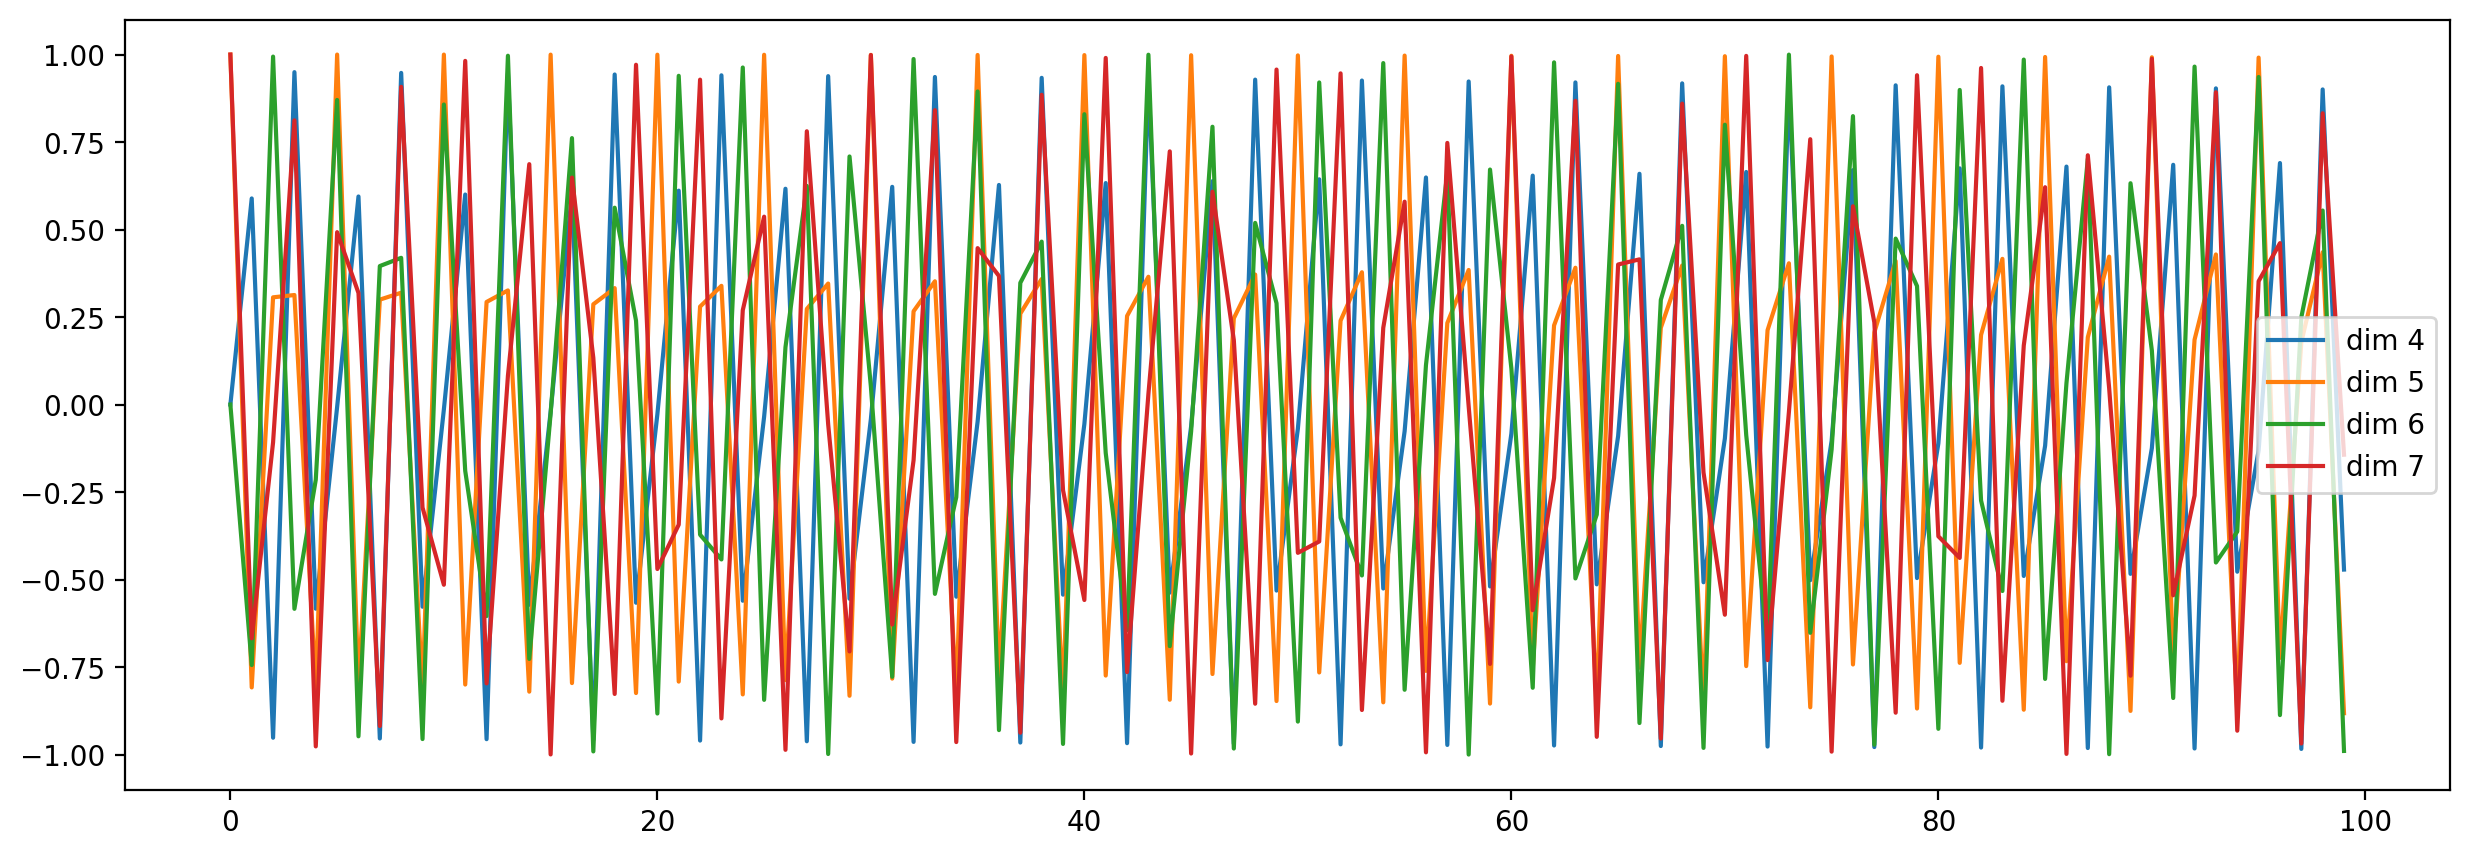

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### <font size='4' color='orange'>Task 2.6: Implement a Transformer-based predictor (5 points)</font>

In [101]:
class TransformerModel(nn.Module):
    """
    A Transformer-based predictor.
    """
    def __init__(self, 
           input_dim: int, num_heads:int, trx_ff_dim: int, num_trx_cells:int, output_dim: int, dropout: float=0.1
        ):
        """
        Inputs:
        - input_dim: input_dimension of the sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - output_dim: output dimension
        - dropout: Dropout ratio
        """
        super(TransformerModel, self).__init__()
        
        ###########################################################################
        # TODO: Define a module for positional encoding, Transformer encoder, and #
        # a output layer                                                          #
        ###########################################################################
        self.positional_encoding = PositionalEncoding(input_dim)
        self.encoder = TransformerEncoder(input_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(input_dim, output_dim)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x, mask=None):
        """
        Inputs:
        - x: Tensor with the shape of BxLxC.
        - mask: Tensor for multi-head attention
        
        Return:
        - y: Tensor with the shape of BxK, where K is the output dimension
        """
        
        
        y = None
        ###########################################################################
        # TODO: Apply positional embedding to the input, which is then fed into   #
        # the encoder. Average pooling is applied then to all the features of all #
        # tokens. Finally, the prediction value are computed based on the pooled features.  #
        ###########################################################################
        x = self.positional_encoding(x)
        x = self.encoder(x, mask)
        x = x.permute(0, 2, 1)  # Reshape for avg_pooling
        x = self.avg_pool(x).squeeze(2)
        y = self.fc(x)
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        
        return y

In [102]:
# Let's run a sanity check of your model
batch_size, input_dim, output_dim, sequence_l = 2, 6, 3, 10
num_heads = 3
trx_ff_dim = 16
num_trx_cells = 2

x = torch.randn(batch_size, sequence_l, input_dim)
mask = None
model = TransformerModel(input_dim=input_dim, num_heads=num_heads, trx_ff_dim=trx_ff_dim, num_trx_cells=num_trx_cells, output_dim=output_dim)
print('x: {}'.format(x.shape))
y = model(x, mask)
assert len(y.shape) == 2 and y.shape[0] == x.shape[0] and y.shape[1] == output_dim
print(y.shape)

x: torch.Size([2, 10, 6])
torch.Size([2, 3])


### <font size='4' color='orange'>Task 2.7: Conduct experiments here</font>
### You are expected to achieve < 50 validate MSE for non-normalized data
### You are expected to achieve < 1 validate MSE for normalized data

In [103]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset

# Try Hyper parameters
epochs = 10 # epoch
lr = 1e-3 # learning rate
batch_size = 64 # batch size for training
num_heads = 3
num_trx_cells = 2
input_dim = 6
output_dim = 2
trx_ff_dim = 30

model, loss_func = None, None
###########################################################################
# TODO: Deinfe the classifier and loss function.
###########################################################################

model = TransformerModel(input_dim, num_heads, trx_ff_dim, num_trx_cells, output_dim)
loss_func = nn.MSELoss()

###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################


model = model.to(device)
total_mse = None
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, 1e-2)

# Change the normalize parameters here to conduct experiment for normalized data or the raw data
X, y = createSamples(data, lookBack=24, normalize=True)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, 1)
    mse_val = evaluate(model, valid_dataloader, loss_func, device)
    if total_mse is not None and total_mse > mse_val:
        scheduler.step()
    else:
        total_mse = mse_val
    if epoch == 100:
        optimizer.param_groups[0]['lr'] = 1e-3
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid mse {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           mse_val))
    #print('-' * 59)

| epoch   1 |   100/  103 batches | MSE    0.001
-----------------------------------------------------------
| end of epoch   1 | time:  2.21s | valid mse    0.000 
| epoch   2 |   100/  103 batches | MSE    0.000
-----------------------------------------------------------
| end of epoch   2 | time:  2.56s | valid mse    0.000 
| epoch   3 |   100/  103 batches | MSE    0.000
-----------------------------------------------------------
| end of epoch   3 | time:  1.48s | valid mse    0.000 
| epoch   4 |   100/  103 batches | MSE    0.000
-----------------------------------------------------------
| end of epoch   4 | time:  1.45s | valid mse    0.000 
| epoch   5 |   100/  103 batches | MSE    0.000
-----------------------------------------------------------
| end of epoch   5 | time:  1.43s | valid mse    0.000 
| epoch   6 |   100/  103 batches | MSE    0.000
-----------------------------------------------------------
| end of epoch   6 | time:  1.46s | valid mse    0.000 
| epoch   